<a href="https://colab.research.google.com/github/samjang03/glucose_companion/blob/main/BrisT1D_dataset_v1_1_edited_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.kaggle.com/code/danishyousuf19/brist1d-dataset

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
from itertools import product
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/Colab Datasets/'

Mounted at /content/drive


In [ ]:
!pip install pydexcom

In [ ]:
from pydexcom import Dexcom
dexcom = Dexcom(username="muryshnaya@gmail.com", password="Vy03062003", region="ous")
glucose_reading = dexcom.get_current_glucose_reading()
print(glucose_reading)
glucose_reading.mmol_l
# glucose_list = dexcom.get_latest_glucose_reading()
# print(glucose_list)

113


6.3

In [ ]:
df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])
df_test = pd.read_csv(path + 'test.csv', index_col='id', parse_dates=['time'])
activities = pd.read_csv(path + 'activities.txt')
print("\nПерші рядки train:")
print(df_train.head())

print("\nРозмір тренувального набору:", df_train.shape)
print("Розмір тестового набору:", df_test.shape)

<ipython-input-5-2b444c68a848>:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])
<ipython-input-5-2b444c68a848>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_train = pd.read_csv(path + 'train.csv', index_col='id', parse_dates=['time'])



Перші рядки train:
      p_num                time  bg-5:55  bg-5:50  bg-5:45  bg-5:40  bg-5:35  \
id                                                                             
p01_0   p01 2025-02-15 06:10:00      NaN      NaN      9.6      NaN      NaN   
p01_1   p01 2025-02-15 06:25:00      NaN      NaN      9.7      NaN      NaN   
p01_2   p01 2025-02-15 06:40:00      NaN      NaN      9.2      NaN      NaN   
p01_3   p01 2025-02-15 06:55:00      NaN      NaN      8.7      NaN      NaN   
p01_4   p01 2025-02-15 07:10:00      NaN      NaN      8.4      NaN      NaN   

       bg-5:30  bg-5:25  bg-5:20  ...  activity-0:40  activity-0:35  \
id                                ...                                 
p01_0      9.7      NaN      NaN  ...            NaN            NaN   
p01_1      9.2      NaN      NaN  ...            NaN            NaN   
p01_2      8.7      NaN      NaN  ...            NaN            NaN   
p01_3      8.4      NaN      NaN  ...            NaN            

<ipython-input-5-2b444c68a848>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_test = pd.read_csv(path + 'test.csv', index_col='id', parse_dates=['time'])


In [ ]:
# Data Preparation

np.random.seed(42)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))

# Replace incompatible column names
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

# Define feature columns (тепер використовуємо всі доступні часові точки)
hours = range(0, 6)   # Last 6 hours
minutes = range(0, 60, 5)  # Every 5 minutes

# Generate feature column names
bg_cols = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]  # Обмежуємо до години
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

# Інтерполяція для глюкози, інсуліну та вуглеводів
for df in [df_train, df_test]:
    df[bg_cols] = df[bg_cols].interpolate(axis=1, limit_direction='both')
    df[insu_cols] = df[insu_cols].interpolate(axis=1, limit_direction='both')
    df[carb_cols] = df[carb_cols].interpolate(axis=1, limit_direction='both')

# Calculate rate of change for glucose
df_train['glucose_rate'] = df_train['bg-0-00'].diff() / 5  # mmol/L per 5 min
df_test['glucose_rate'] = df_test['bg-0-00'].diff() / 5

# Calculate active insulin and carbs
def calculate_active_components(df):
    # Active insulin calculation with weights
    peak_insulin = df[[col for col in insu_cols if '0-' in col or '1-' in col]].sum(axis=1) * 0.95
    active_insulin = df[[col for col in insu_cols if '2-' in col]].sum(axis=1) * 0.7
    residual_insulin = df[[col for col in insu_cols if '3-' in col]].sum(axis=1) * 0.4
    df['estimated_active_insulin'] = peak_insulin + active_insulin + residual_insulin

    # Active carbs (last 2 hours)
    recent_carbs = [col for col in carb_cols if '0-' in col or '1-' in col]
    df['estimated_active_carbs'] = df[recent_carbs].sum(axis=1)

    # Insulin to carb ratio
    df['insulin_carb_ratio'] = (df['estimated_active_insulin'] + 1e-6) / (df['estimated_active_carbs'] + 1e-6)

    return df

df_train = calculate_active_components(df_train)
df_test = calculate_active_components(df_test)

# Add time features
for df in [df_train, df_test]:
    df['sin_hour'] = np.sin(2 * np.pi * df['time'].dt.hour/24)
    df['cos_hour'] = np.cos(2 * np.pi * df['time'].dt.hour/24)

# Combine all features
feature_cols = (bg_cols + insu_cols + carb_cols + hr_cols[:12] + step_cols[:12] +
               cals_cols[:12] + ['glucose_rate', 'estimated_active_insulin',
               'estimated_active_carbs', 'insulin_carb_ratio', 'sin_hour', 'cos_hour'])

# Impute remaining missing values
imputer = SimpleImputer(strategy='mean')
df_train[feature_cols] = imputer.fit_transform(df_train[feature_cols])
df_test[feature_cols] = imputer.transform(df_test[feature_cols])

# Prepare data for modeling
X = df_train[feature_cols]
y = df_train['bg+1-00']
groups = df_train['p_num']



[I 2025-02-15 08:07:02,636] A new study created in memory with name: no-name-98328682-48cf-49e7-9c06-b344e968fc5a


[I 2025-02-14 16:24:27,827] A new study created in memory with name: no-name-2ec26e7f-a593-424a-a39d-97587a906a29
[I 2025-02-14 16:32:36,323] Trial 0 finished with value: 2.072720155193068 and parameters: {'n_estimators': 1839, 'learning_rate': 0.016376943824308498, 'max_depth': 8, 'min_child_samples': 14, 'min_child_weight': 0.06012573412510209, 'subsample': 0.9259591629550588, 'colsample_bytree': 0.5015868256767542, 'reg_alpha': 3.308042726846978e-08, 'reg_lambda': 0.0038318122532709355}. Best is trial 0 with value: 2.072720155193068.
[I 2025-02-14 16:43:06,326] Trial 1 finished with value: 2.079914519084501 and parameters: {'n_estimators': 1684, 'learning_rate': 0.01848111556623715, 'max_depth': 8, 'min_child_samples': 96, 'min_child_weight': 0.0015507550860953457, 'subsample': 0.7753566878496306, 'colsample_bytree': 0.9221805036683148, 'reg_alpha': 0.0002978690002931085, 'reg_lambda': 0.0014956230453848473}. Best is trial 0 with value: 2.072720155193068.
[I 2025-02-14 16:49:57,835]


Best Hyperparameters: {'n_estimators': 842, 'learning_rate': 0.005740066086667151, 'max_depth': 4, 'min_child_samples': 74, 'min_child_weight': 0.026796797352046393, 'subsample': 0.6698126236692951, 'colsample_bytree': 0.7078481349439978, 'reg_alpha': 0.012671001766542194, 'reg_lambda': 0.02218910023582664}

Fold 1:
RMSE: 2.182
MAE: 1.614
R²: 0.517
MARD: 20.124%
Range-specific MAE:
  Hypoglycemia: 3.267
  Normal range: 1.200
  Hyperglycemia: 2.584

Fold 2:
RMSE: 2.204
MAE: 1.576
R²: 0.433
MARD: 17.123%
Range-specific MAE:
  Hypoglycemia: 4.724
  Normal range: 1.082
  Hyperglycemia: 2.502

Fold 3:
RMSE: 1.653
MAE: 1.323
R²: -0.100
MARD: 23.289%
Range-specific MAE:
  Hypoglycemia: 3.346
  Normal range: 1.255
  Hyperglycemia: 2.337

Fold 4:
RMSE: 1.715
MAE: 1.287
R²: 0.633
MARD: 18.228%
Range-specific MAE:
  Hypoglycemia: 3.373
  Normal range: 1.047
  Hyperglycemia: 2.201

Fold 5:
RMSE: 2.020
MAE: 1.540
R²: 0.191
MARD: 22.559%
Range-specific MAE:
  Hypoglycemia: 4.096
  Normal range: 1.3

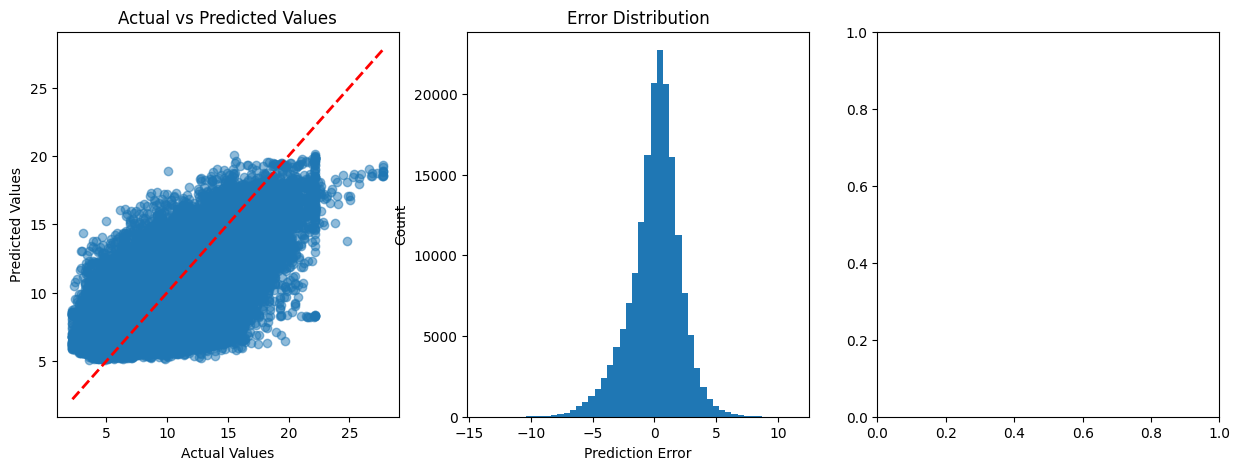

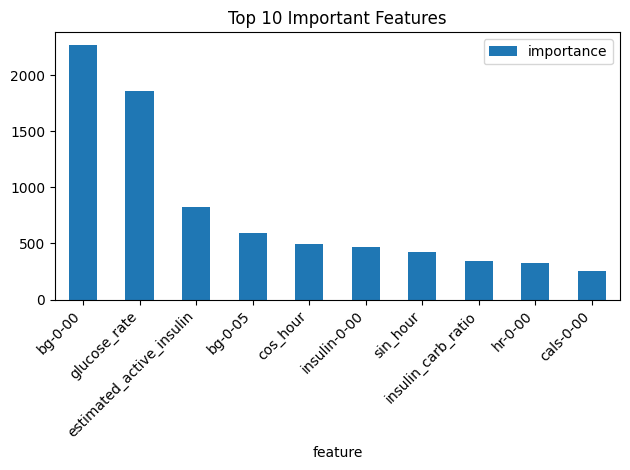


Top 10 Most Important Features:
                     feature  importance
0                    bg-0-00        2269
72              glucose_rate        1859
73  estimated_active_insulin         822
1                    bg-0-05         593
77                  cos_hour         498
12              insulin-0-00         471
76                  sin_hour         425
75        insulin_carb_ratio         346
36                   hr-0-00         330
60                 cals-0-00         252


In [ ]:
# LightGBM

# Define optimization objective with LightGBM parameters
def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e-1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'verbosity': -1
    }

    cv = GroupKFold(n_splits=7)
    rmse_list = []

    for train_idx, valid_idx in cv.split(X, y, groups):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train,
                 eval_set=[(X_valid, y_valid)])

        y_pred = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
        rmse_list.append(rmse)

    return np.mean(rmse_list)

# Run optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print results and train final model
print("\nBest Hyperparameters:", study.best_params)

# Initialize and train final model with best parameters
final_model = lgb.LGBMRegressor(**study.best_params)

# Initialize lists for metrics
rmse_scores = []
mae_scores = []
r2_scores = []
mard_scores = []
range_metrics = []

# Calculate MARD
def calculate_mard(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate range-specific metrics
def calculate_range_metrics(y_true, y_pred):
    hypo_mask = y_true < 3.9
    hypo_mae = mean_absolute_error(y_true[hypo_mask], y_pred[hypo_mask]) if hypo_mask.any() else None

    normal_mask = (y_true >= 3.9) & (y_true <= 10.0)
    normal_mae = mean_absolute_error(y_true[normal_mask], y_pred[normal_mask])

    hyper_mask = y_true > 10.0
    hyper_mae = mean_absolute_error(y_true[hyper_mask], y_pred[hyper_mask])

    return {
        'hypo_mae': hypo_mae,
        'normal_mae': normal_mae,
        'hyper_mae': hyper_mae
    }

# Cross-validation with extended metrics calculation
cv = GroupKFold(n_splits=7)
predictions = []
actuals = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y, groups)):
    print(f"\nFold {fold + 1}:")
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    final_model.fit(X_train, y_train,
                   eval_set=[(X_valid, y_valid)])

    y_pred = final_model.predict(X_valid)
    predictions.extend(y_pred)
    actuals.extend(y_valid)

    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)
    mard = calculate_mard(y_valid, y_pred)
    range_met = calculate_range_metrics(y_valid, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    mard_scores.append(mard)
    range_metrics.append(range_met)

    print(f"RMSE: {rmse:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R²: {r2:.3f}")
    print(f"MARD: {mard:.3f}%")
    print("Range-specific MAE:")
    print(f"  Hypoglycemia: {range_met['hypo_mae']:.3f}" if range_met['hypo_mae'] else "  Hypoglycemia: N/A")
    print(f"  Normal range: {range_met['normal_mae']:.3f}")
    print(f"  Hyperglycemia: {range_met['hyper_mae']:.3f}")

# Print average metrics
print("\nOverall Model Performance:")
print(f"Average RMSE: {np.mean(rmse_scores):.3f} (+/- {np.std(rmse_scores):.3f})")
print(f"Average MAE: {np.mean(mae_scores):.3f} (+/- {np.std(mae_scores):.3f})")
print(f"Average R²: {np.mean(r2_scores):.3f} (+/- {np.std(r2_scores):.3f})")
print(f"Average MARD: {np.mean(mard_scores):.3f}% (+/- {np.std(mard_scores):.3f}%)")

# Calculate average range-specific metrics
avg_hypo_mae = np.mean([m['hypo_mae'] for m in range_metrics if m['hypo_mae'] is not None])
avg_normal_mae = np.mean([m['normal_mae'] for m in range_metrics])
avg_hyper_mae = np.mean([m['hyper_mae'] for m in range_metrics])

print("\nAverage Range-specific MAE:")
print(f"Hypoglycemia: {avg_hypo_mae:.3f}")
print(f"Normal range: {avg_normal_mae:.3f}")
print(f"Hyperglycemia: {avg_hyper_mae:.3f}")

# Visualization
plt.figure(figsize=(15, 5))

# 1. Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# 2. Prediction Error Distribution
plt.subplot(1, 3, 2)
errors = np.array(predictions) - np.array(actuals)
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')

# 3. Feature Importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(1, 3, 3)
importance_df.head(10).plot(x='feature', y='importance', kind='bar')
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Important Features')

plt.tight_layout()
plt.show()

# Save importance to dataframe
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Save model
final_model.booster_.save_model('best_model.txt')

## Базовий аналіз струкури даних

In [ ]:
def analyze_dataset(df, name="Dataset"):
    """
    Функція для аналізу структури набору даних

    Parameters:
    df (DataFrame): набір даних для аналізу
    name (str): назва набору даних для виведення

    Returns:
    dict: словник з назвами колонок різних типів даних
    """
    print(f"\n{name} Analysis:")
    print("-" * 50)
    print(f"Shape: {df.shape}")

    print("\nColumns by type:")
    print(df.dtypes.value_counts())

    # Аналіз пропущених значень з відсотками
    print("\nMissing values:")
    missing = df.isnull().sum()
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing[missing > 0],
        'Percent': missing_percent[missing > 0]
    }).round(2)
    print(missing_data)

    # Групуємо колонки за типами даних
    bg_cols = [col for col in df.columns if 'bg' in col.lower()]
    insulin_cols = [col for col in df.columns if 'insulin' in col.lower()]
    carbs_cols = [col for col in df.columns if 'carbs' in col.lower()]
    activity_cols = [col for col in df.columns if 'activity' in col.lower()]

    print("\nFeature groups:")
    print(f"Blood glucose columns: {len(bg_cols)}")
    print(f"Insulin columns: {len(insulin_cols)}")
    print(f"Carbohydrate columns: {len(carbs_cols)}")
    print(f"Activity columns: {len(activity_cols)}")

    return {
        'bg_cols': bg_cols,
        'insulin_cols': insulin_cols,
        'carbs_cols': carbs_cols,
        'activity_cols': activity_cols
    }

In [ ]:
def analyze_value_ranges(df):
    """
    Функція для аналізу діапазонів значень у наборі даних

    Parameters:
    df (DataFrame): набір даних для аналізу

    Returns:
    dict: словник зі статистичними показниками для різних груп даних
    """
    # Виділення колонок для різних типів даних
    bg_cols = [col for col in df.columns if 'bg' in col and col != 'bg+1:00']
    insulin_cols = [col for col in df.columns if 'insulin' in col]
    carbs_cols = [col for col in df.columns if 'carbs' in col]

    # Розрахунок статистик
    bg_stats = df[bg_cols].describe()
    insulin_stats = df[insulin_cols].describe()
    carbs_stats = df[carbs_cols].describe()
    target_stats = df['bg+1:00'].describe() if 'bg+1:00' in df.columns else None

    # Додаткова статистика по прийомам їжі
    nonzero_carbs = df[carbs_cols][df[carbs_cols] > 0]
    carbs_summary = {
        'total_meals': (df[carbs_cols] > 0).any(axis=1).sum(),
        'avg_meal_size': nonzero_carbs.mean().mean() if not nonzero_carbs.empty else 0,
        'max_meal_size': df[carbs_cols].max().max()
    }

    print("Статистика значень глюкози:")
    print(bg_stats.round(2))

    print("\nСтатистика значень інсуліну:")
    print(insulin_stats.round(2))

    print("\nСтатистика значень вуглеводів:")
    print(carbs_stats.round(2))

    if target_stats is not None:
        print("\nСтатистика цільової змінної:")
        print(target_stats.round(2))

    return {
        'bg_stats': bg_stats,
        'insulin_stats': insulin_stats,
        'carbs_stats': carbs_stats,
        'target_stats': target_stats,
        'carbs_summary': carbs_summary
    }

# Використання функцій
print("Аналіз наборів даних:")
train_features = analyze_dataset(train, "Training Dataset")
test_features = analyze_dataset(test, "Test Dataset")

print("\nАналіз діапазонів значень:")
train_stats = analyze_value_ranges(train)

Аналіз наборів даних:

Training Dataset Analysis:
--------------------------------------------------
Shape: (177024, 508)

Columns by type:
float64    433
object      75
Name: count, dtype: int64

Missing values:
               Missing Values  Percent
bg-5:55                 27254    15.40
bg-5:50                 18491    10.45
bg-5:45                 13660     7.72
bg-5:40                 27258    15.40
bg-5:35                 18770    10.60
...                       ...      ...
activity-0:20          174270    98.44
activity-0:15          174293    98.46
activity-0:10          174287    98.45
activity-0:05          174271    98.44
activity-0:00          174287    98.45

[504 rows x 2 columns]

Feature groups:
Blood glucose columns: 73
Insulin columns: 72
Carbohydrate columns: 72
Activity columns: 72

Test Dataset Analysis:
--------------------------------------------------
Shape: (3644, 507)

Columns by type:
float64    432
object      75
Name: count, dtype: int64

Missing values:
 


Time in Range аналіз:
Тяжка гіпоглікемія: 0.0%
Гіпоглікемія: 0.1%
Цільовий діапазон: 80.7%
Гіперглікемія: 17.1%
Тяжка гіперглікемія: 2.1%

Метрики варіабельності:
Середнє значення: 8.28
Стандартне відхилення: 2.19
Коефіцієнт варіації (%): 26.43
Мінімум: 2.8
Максимум: 24.62
Міжквартильний розмах: 2.78


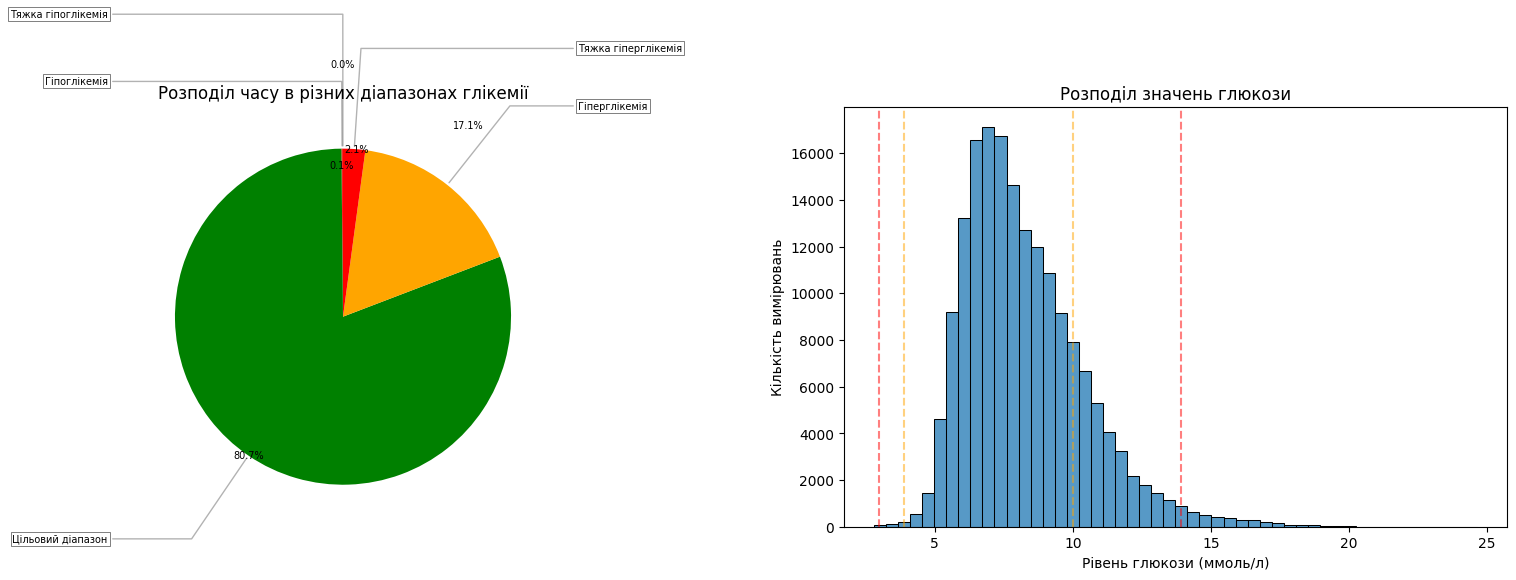

In [ ]:
def analyze_time_in_range(df, column='bg-0:00'):
    """
    Аналіз Time in Range для глюкози
    """
    # Визначення діапазонів згідно з міжнародними рекомендаціями
    ranges = {
        'Тяжка гіпоглікемія': (0, 3.0),
        'Гіпоглікемія': (3.0, 3.9),
        'Цільовий діапазон': (3.9, 10.0),
        'Гіперглікемія': (10.0, 13.9),
        'Тяжка гіперглікемія': (13.9, float('inf'))
    }

    # Розрахунок часу в кожному діапазоні
    time_in_range = {}
    total_valid = df[column].notna().sum()

    for name, (min_val, max_val) in ranges.items():
        mask = (df[column] >= min_val) & (df[column] < max_val)
        percentage = (mask.sum() / total_valid * 100).round(2)
        time_in_range[name] = percentage

    return pd.Series(time_in_range)

def calculate_variability_metrics(df, column='bg-0:00'):
    """
    Розрахунок метрик варіабельності глюкози
    """
    mean_val = float(df[column].mean())
    std_val = float(df[column].std())

    metrics = {
        'Середнє значення': round(mean_val, 2),
        'Стандартне відхилення': round(std_val, 2),
        'Коефіцієнт варіації (%)': round((std_val / mean_val * 100), 2),
        'Мінімум': round(float(df[column].min()), 2),
        'Максимум': round(float(df[column].max()), 2),
        'Міжквартильний розмах': round(float(df[column].quantile(0.75) - df[column].quantile(0.25)), 2)
    }

    return pd.Series(metrics)

def plot_time_in_range_analysis(df, column='bg-0:00'):
    """
    Візуалізація аналізу Time in Range
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Time in Range діаграма
    time_in_range = analyze_time_in_range(df, column)
    colors = ['black', 'red', 'green', 'orange', 'red']

    # Створення кругової діаграми з правильним розміщенням міток
    wedges, texts = ax1.pie(
        time_in_range.values,
        labels=None,  # Прибираємо вбудовані мітки
        colors=colors,
        startangle=90
    )

    # Додаткове ручне розміщення відсоткових міток
    manual_offsets = {
        0: (1.2, 0.3),   # Тяжка гіпоглікемія
        1: (1.2, -0.3),  # Гіпоглікемія
        2: (1.0, 0),     # Цільовий діапазон
        3: (1.2, 0.2),   # Гіперглікемія
        4: (1.2, -0.2)   # Тяжка гіперглікемія
    }

    for i, (wedge, label) in enumerate(zip(wedges, time_in_range.index)):
        ang = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        # Розміщення відсоткової мітки
        offset_x, offset_y = manual_offsets[i]
        ax1.text(x*offset_x, y*offset_x + offset_y, f'{time_in_range.values[i]:.1f}%',
                 ha='center', va='center', fontsize=7)

    # Додавання правильних міток
    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.5, alpha=0.7)
    kw = dict(arrowprops=dict(arrowstyle="-", color='gray', alpha=0.6),
              bbox=bbox_props, zorder=0, va="center", fontsize=7)

    y_offsets = [0.2, -0.2, 0, 0, 0]

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))

        x_multiplier = 1.4
        y_multiplier = 1.6

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw['arrowprops'].update({"connectionstyle": connectionstyle})

        ax1.annotate(time_in_range.index[i],
                     xy=(x, y),
                     xytext=(x_multiplier*np.sign(x), y_multiplier*y + y_offsets[i]),
                     horizontalalignment=horizontalalignment,
                     **kw)

    ax1.set_title('Розподіл часу в різних діапазонах глікемії')

    # Графік розподілу значень глюкози
    sns.histplot(data=df, x=column, bins=50, ax=ax2)

    # Додавання вертикальних ліній для діапазонів
    ax2.axvline(x=3.0, color='r', linestyle='--', alpha=0.5)
    ax2.axvline(x=3.9, color='orange', linestyle='--', alpha=0.5)
    ax2.axvline(x=10.0, color='orange', linestyle='--', alpha=0.5)
    ax2.axvline(x=13.9, color='r', linestyle='--', alpha=0.5)

    ax2.set_title('Розподіл значень глюкози')
    ax2.set_xlabel('Рівень глюкози (ммоль/л)')
    ax2.set_ylabel('Кількість вимірювань')

    plt.tight_layout()
    return fig

def analyze_and_plot_glucose_data(df, pattern='bg-'):
    """
    Комплексний аналіз даних глюкози з використанням усіх bg- колонок
    """
    # Знаходимо всі колонки з bg-
    bg_columns = [col for col in df.columns if pattern in col]

    # Створюємо колонку з середніми значеннями
    df_analysis = df.copy()
    df_analysis['mean_glucose'] = df[bg_columns].mean(axis=1)

    # Розрахунок метрик
    tir = analyze_time_in_range(df_analysis, column='mean_glucose')
    variability = calculate_variability_metrics(df_analysis, column='mean_glucose')

    # Виведення результатів
    print("\nTime in Range аналіз:")
    print("="*50)
    for range_name, percentage in tir.items():
        print(f"{range_name}: {percentage:.1f}%")

    print("\nМетрики варіабельності:")
    print("="*50)
    for metric_name, value in variability.items():
        print(f"{metric_name}: {value}")

    # Створення візуалізації
    fig = plot_time_in_range_analysis(df_analysis, column='mean_glucose')

    return tir, variability, fig

# Виклик функції
tir, variability, fig = analyze_and_plot_glucose_data(train)
plt.show()